<a href="https://colab.research.google.com/github/machine-perception-robotics-group/ImageProcessingGoogleColabNotebooks/blob/master/06_template_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. テンプレートマッチング
講義で説明する画像処理の方法について，google colaboratoryを利用して演習する．
google colaboratoryは，クラウドで実行する Jupyter ノートブック環境である.
google coraboratoryについては，[ここ](https://www.tdi.co.jp/miso/google-colaboratory-gpu)や[ここ](https://www.codexa.net/how-to-use-google-colaboratory/)を参考にすること．

下記のプログラムを実行すると，様々な類似尺度を用いたテンプレートマッチングや高速化のための粗密探索を実行する．

## 準備
プログラムの動作に必要なデータをダウンロードし，zipファイルを解凍する．
`!`で始まるコマンドはPythonではなく，Linux（Ubuntu）のコマンドを実行している．

In [2]:
!wget -q http://www.mprg.cs.chubu.ac.jp/Tutorial/ML_Lecture/tutorial_ip_2020/image1.zip
!unzip -q image1.zip
!ls
!ls ./image1/

image1	image1.zip  sample_data
168065B.JPG	 Blackboard3.jpg  woman-color.jpg  woman-n.jpg
Blackboard1.jpg  coin.png	  woman-g2.jpg	   woman-s.jpg
Blackboard2.jpg  ipod.png	  woman-g.jpg	   woman-t.jpg


## 画像の読み込みと表示
必要なパッケージをインポートし，画像を表示する．

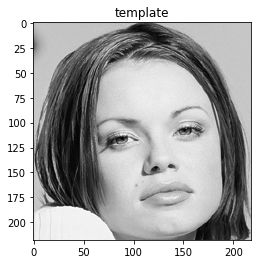

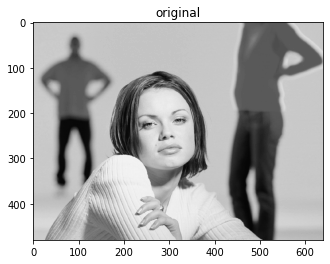

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('./image1/woman-t.jpg', 0)
img2 = cv2.imread('./image1/woman-g.jpg', 0)

plt.imshow(img1, cmap="gray")
plt.title("template")
plt.show()

plt.imshow(img2, cmap="gray")
plt.title("original")
plt.show()

## 類似尺度
ここではテンプレートマッチングを行う．
テンプレートマッチングでは，テンプレートと入力画像の画素比較によって類似度を算出する．類似度の高い位置を算出することで入力画像中のテンプレート画像位置を探索できる．

In [0]:
import math

def ssd(img1, img2):
  img1 = np.float32(img1.flatten())
  img2 = np.float32(img2.flatten())

  diff = img1 - img2
  ssd_val = np.sum(diff**2)
  return ssd_val

  
def sad(img1, img2):
  img1 = np.float32(img1.flatten())
  img2 = np.float32(img2.flatten())
  
  sad_val = np.sum(np.abs(img1 - img2))
  return sad_val


def norm_cross_correlation(img1, img2):
  img1 = np.float32(img1.flatten())
  img2 = np.float32(img2.flatten())
  
  sum1 = np.sum(img1**2)
  sum2 = np.sum(img2**2)
  sum_prod = np.sum(img1 * img2)
  ncc_val = sum_prod / math.sqrt(sum1 * sum2)
  return ncc_val


def zeromean_norm_cross_correlation(img1, img2):
  img1 = np.float32(img1.flatten())
  img2 = np.float32(img2.flatten())

  mean1 = np.mean(img1)
  mean2 = np.mean(img2)

  subtract_mean1 = img1 - mean1
  subtract_mean2 = img2 - mean2

  sum1 = np.sum(subtract_mean1**2)
  sum2 = np.sum(subtract_mean2**2)

  sum_prod = np.sum(subtract_mean1 * subtract_mean2)

  zm_ncc_val = sum_prod / math.sqrt(sum1 * sum2)
  return zm_ncc_val

指定した画像とテンプレートでテンプレートマッチングを行うための関数を定義する．

In [0]:
def matching_template(img, template, metric, find_min=True):
  h, w = img.shape
  ht, wt = template.shape
  template_score = np.zeros([h - ht, w - wt], dtype=np.float32)

  for y in range(h - ht):
    for x in range(w - wt):
      template_score[y, x] = metric(img[y:y+ht, x:x+wt], template)
  
  if find_min:
    top_left = np.unravel_index(np.argmin(template_score), template_score.shape)
  else:
    top_left = np.unravel_index(np.argmax(template_score), template_score.shape)

  bottom_right = (top_left[0] + ht, top_left[1] + wt)
  return template_score, top_left[::-1], bottom_right[::-1]

### SSD



found coordinate (x, y)
   top-left    : (168, 108)
   bottom-right: (386, 326)


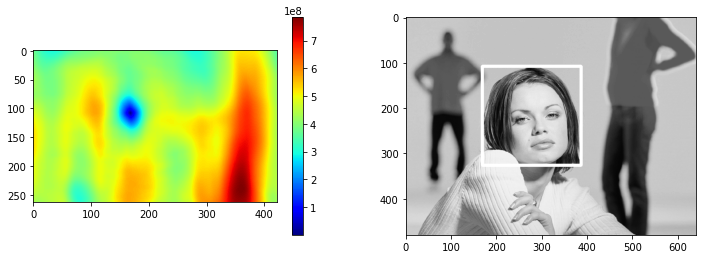

In [6]:
img = img2.copy()
template = img1.copy()

ssd_score, top_left_coord, bottom_right_coord = matching_template(img, template, ssd)

print("found coordinate (x, y)")
print("   top-left    :", top_left_coord)
print("   bottom-right:", bottom_right_coord)

cv2.rectangle(img, top_left_coord, bottom_right_coord, 255, 5)

plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(ssd_score, cmap="jet")
plt.colorbar()
plt.subplot(122), plt.imshow(img, cmap="gray")
plt.show()

### SAD



found coordinate (x, y)
   top-left    : (168, 108)
   bottom-right: (386, 326)


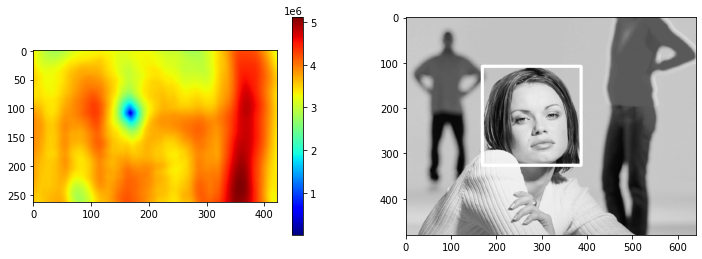

In [7]:
img = img2.copy()
template = img1.copy()

sad_score, top_left_coord, bottom_right_coord = matching_template(img, template, sad)

print("found coordinate (x, y)")
print("   top-left    :", top_left_coord)
print("   bottom-right:", bottom_right_coord)

cv2.rectangle(img, top_left_coord, bottom_right_coord, 255, 5)

plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(sad_score, cmap="jet")
plt.colorbar()
plt.subplot(122), plt.imshow(img, cmap="gray")
plt.show()

### Normalized Cross Correlation


found coordinate (x, y)
   top-left    : (168, 108)
   bottom-right: (386, 326)


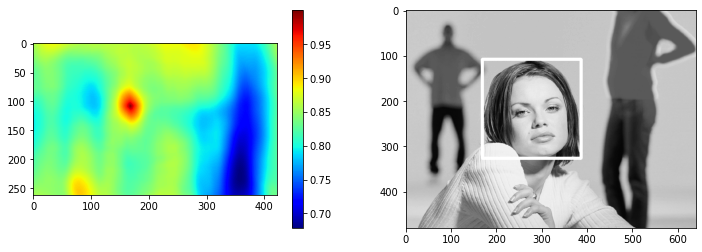

In [8]:
img = img2.copy()
template = img1.copy()

ncc_score, top_left_coord, bottom_right_coord = matching_template(img, template, norm_cross_correlation, find_min=False)

print("found coordinate (x, y)")
print("   top-left    :", top_left_coord)
print("   bottom-right:", bottom_right_coord)

cv2.rectangle(img, top_left_coord, bottom_right_coord, 255, 5)

plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(ncc_score, cmap="jet")
plt.colorbar()
plt.subplot(122), plt.imshow(img, cmap="gray")
plt.show()

### Zero-means Normalized Cross-Correlation


found coordinate (x, y)
   top-left    : (168, 108)
   bottom-right: (386, 326)


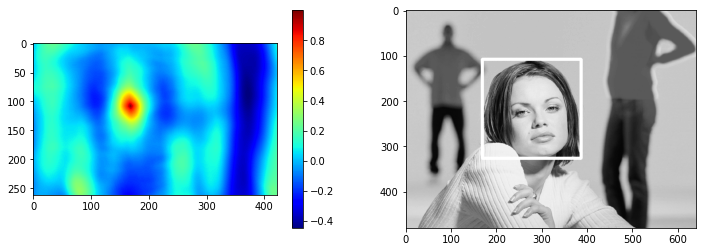

In [9]:
img = img2.copy()
template = img1.copy()

zm_ncc_score, top_left_coord, bottom_right_coord = matching_template(img, template, zeromean_norm_cross_correlation, find_min=False)

print("found coordinate (x, y)")
print("   top-left    :", top_left_coord)
print("   bottom-right:", bottom_right_coord)

cv2.rectangle(img, top_left_coord, bottom_right_coord, 255, 5)

plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(zm_ncc_score, cmap="jet")
plt.colorbar()
plt.subplot(122), plt.imshow(img, cmap="gray")
plt.show()

## 粗密探索

低解像度画像で探索を開始し，その結果近傍のみで高解像度探索を行う

In [10]:
import time

img = img2.copy()
template = img1.copy()

time_start1 = time.time()
zm_ncc_score, top_left_coord, bottom_right_coord = matching_template(img, template, zeromean_norm_cross_correlation, find_min=False)
time_end1 = time.time()
print("found top-left coordinate:", top_left_coord)
print("processing time:", time_end1 - time_start1, "[s]")

found top-left coordinate: (168, 108)
processing time: 24.401468515396118 [s]


found top-left coordinate (small)   : (42, 27)
found top-left coordinate (trimmed) : (0, 3)
found top-left coordinate (original): (168, 111)
processing time: 0.4349949359893799 [s]


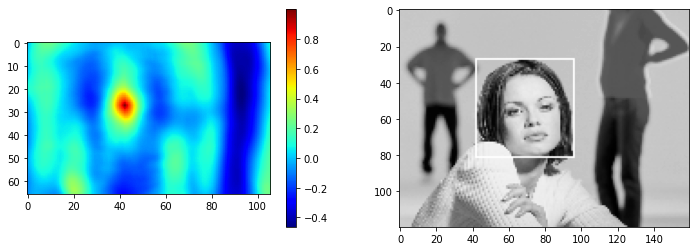

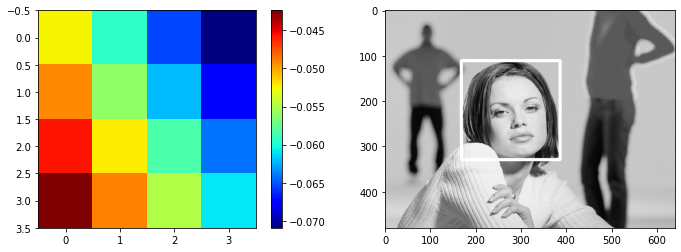

In [11]:
img = img2.copy()
template = img1.copy()
ht, wt = template.shape

# 画像を1/4のサイズにリサイズ
img_small = cv2.resize(img, None, fx=0.25, fy=0.25)
template_small = cv2.resize(template, None, fx=0.25, fy=0.25)

time_start2 = time.time()
# 小さな画像でテンプレートマッチング
score_s, tl_s, br_s = matching_template(img_small, template_small, zeromean_norm_cross_correlation, find_min=False)
print("found top-left coordinate (small)   :", tl_s)

# 小さい画像に対応する領域を元画像から抽出
img_trimmed = img[tl_s[0]*4:(tl_s[0]+1)*4+ht, tl_s[1]*4:(tl_s[1]+1)*4+wt]

# 対応領域を抽出した画像でテンプレートマッチング
score, tl, br = matching_template(img_trimmed, template, zeromean_norm_cross_correlation, find_min=False)
print("found top-left coordinate (trimmed) :", tl)

# 得られた座標を元画像中の座標に変換
top_left = (tl[0] + tl_s[0]*4, tl[1] + tl_s[1]*4)
bottom_right = (br[0] + tl_s[0]*4, br[1] + tl_s[1]*4)
print("found top-left coordinate (original):", top_left)
time_end2 = time.time()
print("processing time:", time_end2 - time_start2, "[s]")

# 結果の描画
cv2.rectangle(img_small, tl_s, br_s, 255, 1)
cv2.rectangle(img, top_left, bottom_right, 255, 5)

# 表示
plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(score_s, cmap="jet")
plt.colorbar()
plt.subplot(122), plt.imshow(img_small, cmap="gray")
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(score, cmap="jet")
plt.colorbar()
plt.subplot(122), plt.imshow(img, cmap="gray")
plt.show()

## OpenCVを用いた方法

OpenCVにはテンプレートマッチングを行うための，`matchTemplate`関数がある．
この関数では，いくつかの類似尺度を使用することができる．

以下では，`matchTemplate`関数を用いて，それぞれの類似尺度を用いた場合の結果を示す．

processing time: 0.01996445655822754 [s]


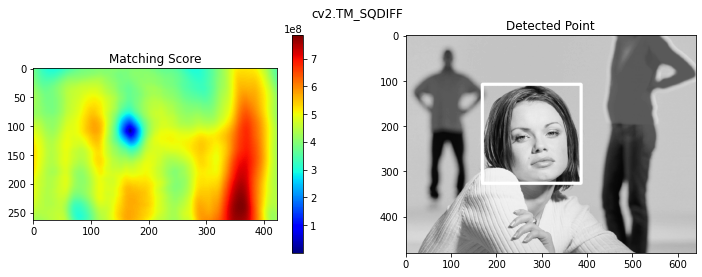

processing time: 0.02742481231689453 [s]


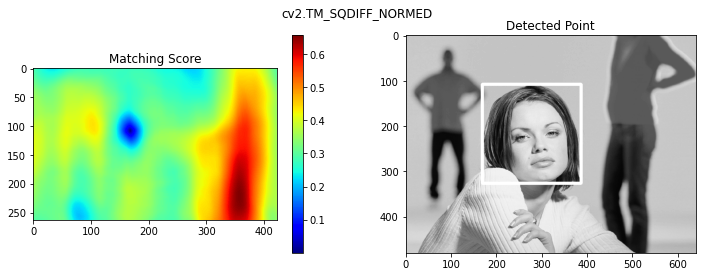

processing time: 0.019366979598999023 [s]


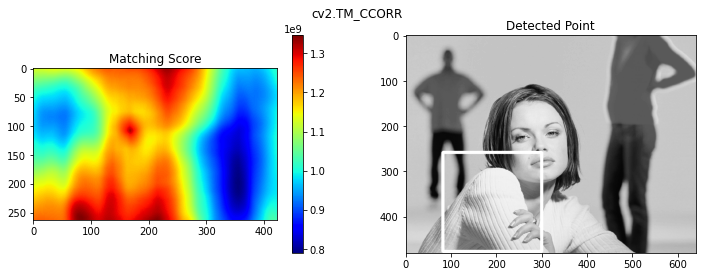

processing time: 0.02423548698425293 [s]


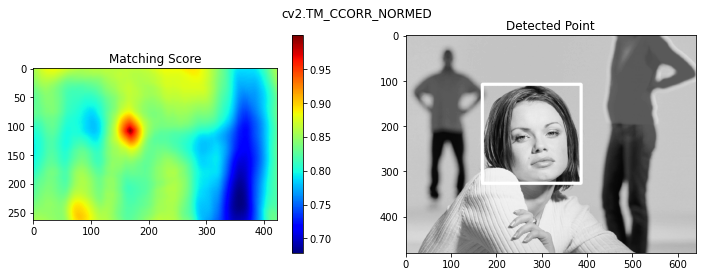

processing time: 0.023829936981201172 [s]


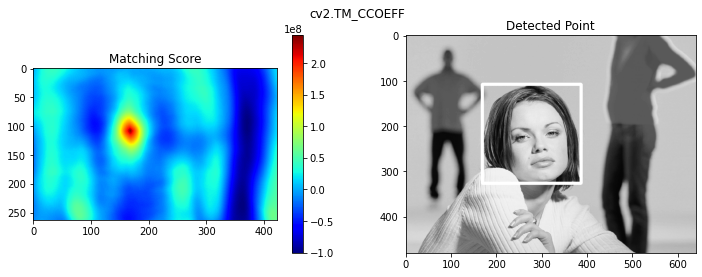

processing time: 0.025098800659179688 [s]


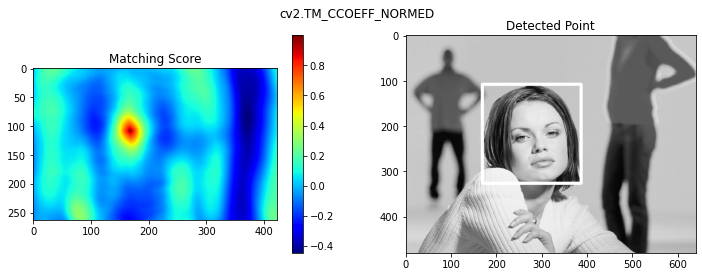

In [16]:
template = img1.copy()
h, w = template.shape

# 6つの方法で比較を行う
methods = ['cv2.TM_SQDIFF',         # 差分相関 (SSD)
           'cv2.TM_SQDIFF_NORMED',  # 正規化差分相関
           'cv2.TM_CCORR',          # 相互相関
           'cv2.TM_CCORR_NORMED',   # 正規化相互相関
           'cv2.TM_CCOEFF',         # 相関係数
           'cv2.TM_CCOEFF_NORMED']  # 正規化相関係数



# 上で定義した方法を一つづつ実行
for meth in methods:
  img = img2.copy()
  method = eval(meth)

  time_start3 = time.time()
  
  # テンプレートマッチング
  res = cv2.matchTemplate(img, template, method)
  min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

  # メソッドが TM_SQDIFF または TM_SQDIFF_NORMED の場合は，最小値を取る
  if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
    top_left = min_loc
  else:
    top_left = max_loc
  bottom_right = (top_left[0] + w, top_left[1] + h)

  time_end3 = time.time()
  print("processing time:", time_end3 - time_start3, "[s]")

  cv2.rectangle(img,top_left, bottom_right, 255, 5)

  plt.figure(figsize=(12, 4))
  plt.subplot(121), plt.imshow(res, cmap='jet')
  plt.title('Matching Score')
  plt.colorbar()
  plt.subplot(122), plt.imshow(img, cmap='gray')
  plt.title('Detected Point')
  plt.suptitle(meth)

  plt.show()

## 課題


In [0]:
06課題
・ヒートマップを観察して，考察すること
・各手法の処理時間を比較し，考察すること